# ResNet vs ResNetAttention

In [1]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import clear_output

sys.path.append('..')
sys.path.append('../task_02')

from dataset import Pipeline, DatasetIndex, Dataset, B, V

from dataset.opensets import MNIST
from dataset.models.tf import ResNetAttention56, ResNet50
from noised_mnist import NoisedMnist                                          # Batch subclass with loading and noise actions

In [2]:
IMAGE_SIZE = 128     # image size
MNIST_SIZE = 65000  # MNIST database size
BATCH_SIZE = 32     # batch size for NN training
MAX_ITER = 10000      # number of iterations for NN training

In [3]:
level = 1           # the highest level of noise; [0, 1]
n_fragments = 150    # number of noise fragments per image  
size = 6            # size of noise fragment; 1, ..., 27
distr = 'uniform'   # distribution of fragments of image; 'uniform' or 'normal'

In [4]:
mnistset = MNIST(batch_class=NoisedMnist)

Extracting ExtractingExtractingExtractingC:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gz   
C:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gz




In [5]:
load_template = (Pipeline()
                 .random_location(IMAGE_SIZE)      # put MNIST at random location
                 .make_masks()                     # create mask for MNIST image location
                 .create_noise('mnist_noise', level, n_fragments, size, distr)
                 .add_noise())

In [6]:
placeholders_config = {
                       'images': {'shape': (IMAGE_SIZE, IMAGE_SIZE, 1),
                                 'type': 'float32',
                                 'data_format': 'channels_last'},
                
                       'labels': {'classes': 10,
                                  'dtype': 'int32',
                                  'transform': 'ohe',
                                  'name': 'targets'}
                       }

In [7]:
model_config = {'inputs': placeholders_config,
                'input_block/inputs': 'images',
                'loss': 'softmax_cross_entropy',
                'output': {'ops': ['proba', 'accuracy']},
                'head/units': [100, 100, 2],
                'optimizer': 'Adam'}

train_feed_dict = {'images': B('images'),
                   'labels': B('labels')}        

test_feed_dict = {'images': B('images'),
                  'labels': B('labels')}

In [8]:
batch = (load_template << mnistset.train).next_batch(5)

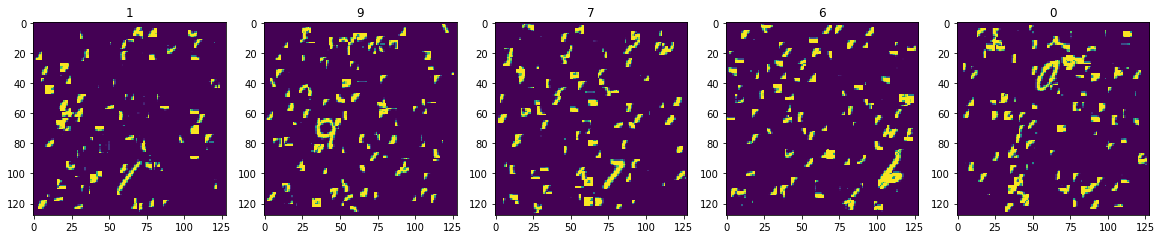

In [9]:
plt.figure(figsize=(20,15))
for i in range(len(batch)):
    plt.subplot(1, len(batch), i+1)
    plt.imshow(np.squeeze(batch.data.images[i]))
    plt.title(batch.data.labels[i])
plt.show()

In [10]:
def test_model(model, n_iter, plot=False):
    train_pp = ((load_template << mnistset.train)
                .init_model('static', model, 'model', config=model_config)
                .init_variable('loss', init_on_each_run=list)
                .train_model('model', fetches=['loss'], feed_dict=train_feed_dict, save_to=V('loss'), mode='e'))

    test_pp = ((load_template << mnistset.test)
                .import_model('model', train_pp)
                .init_variable('predicted_labels', init_on_each_run=list)
                .init_variable('acc', init_on_each_run=list)
                .predict_model('model', 
                               fetches=['predicted_labels', 'accuracy'], 
                               feed_dict=test_feed_dict, 
                               save_to=[V('predicted_labels'), V('acc')], 
                               mode='a'))

    train_time = []
    iter_time = []
    acc = [0]
    for i in range(n_iter):
        start = time()
        train_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None, drop_last=False)
        train_time.append(time()-start)
        
        if (i+1) % 10 == 0:  
            batch = test_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None, drop_last=False)
            acc = test_pp.get_variable('acc')
        loss = train_pp.get_variable('loss')
        iter_time.append(time()-start)
        
        time_remaining = (n_iter - i - 1) * np.mean(iter_time)
        clear_output(True)
        if plot:
            plt.figure(figsize=(30, 10))
            plt.subplot(1, 2, 1)
            plt.plot(loss)
            current_max = np.max(loss[-100:])
            plt.ylim((0, current_max))
            plt.title('Train loss')
            plt.subplot(1, 2, 2)
            plt.plot(acc)
            plt.title('Test accuracy')
            plt.show()
        print("Estimated time remaining: {:5.2f} mins".format(time_remaining/60))

    print("Time per iter: {:3.2f} sec".format(np.mean(train_time)))
    return loss, acc, train_time, train_pp

### ResNetAttention56 training time

In [11]:
_ = test_model(ResNetAttention56, 100)

Estimated time remaining:  0.00 mins
Time per iter: 0.67 sec


### ResNet50 training time

In [12]:
_ = test_model(ResNet50, 100)

Estimated time remaining:  0.00 mins
Time per iter: 0.70 sec


### ResNetAttention56 training

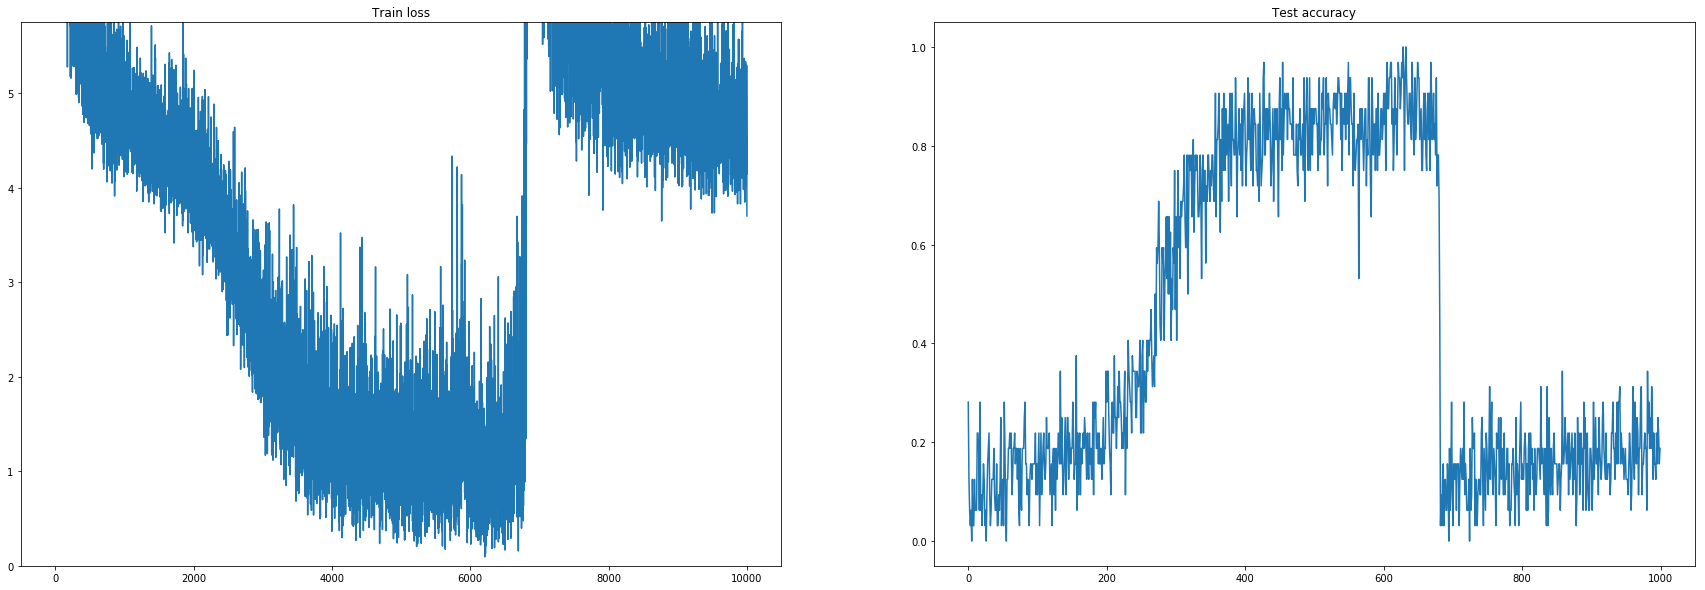

Estimated time remaining:  0.00 mins
Time per iter: 0.64 sec


In [13]:
resnetattention = test_model(ResNetAttention56, MAX_ITER, True)

### ResNet50 training

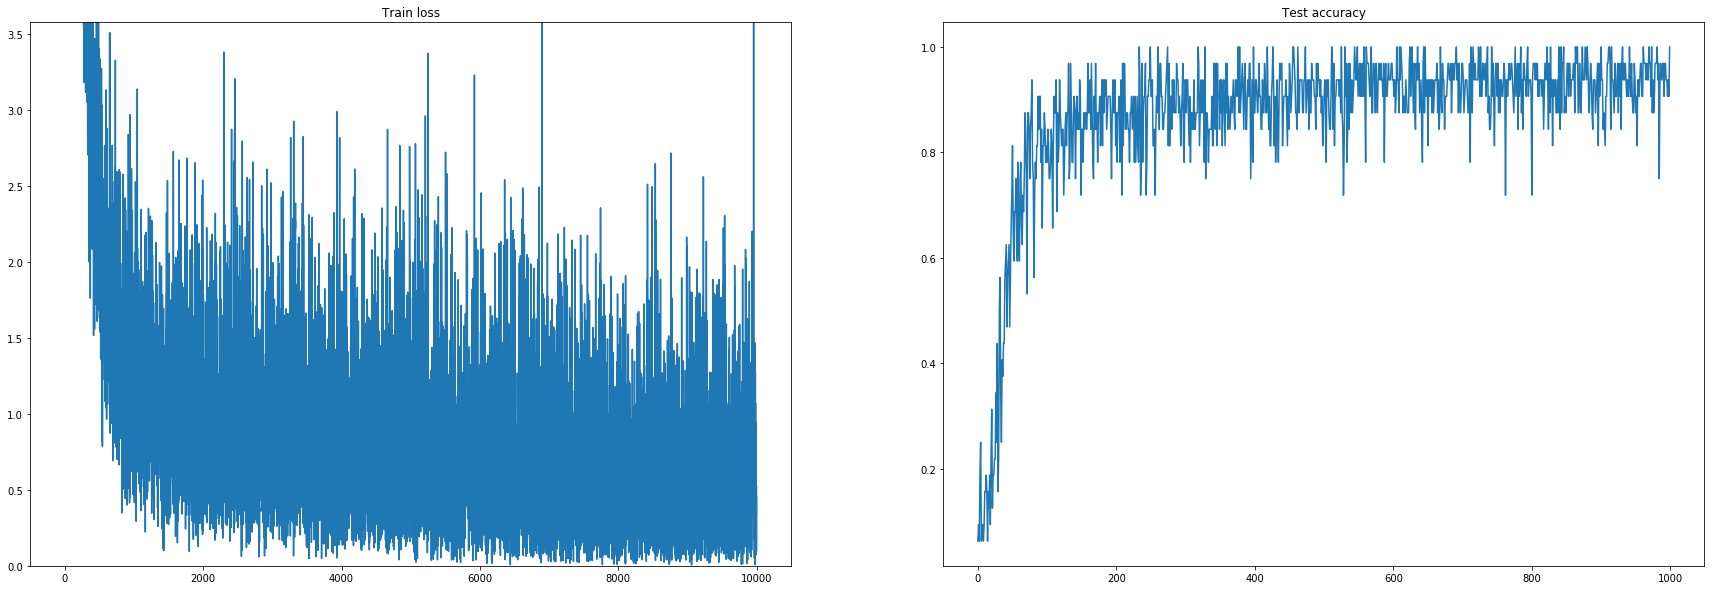

Estimated time remaining:  0.00 mins
Time per iter: 0.78 sec


In [14]:
resnet = test_model(ResNet50, MAX_ITER, True)

In [15]:
def smooth(y, window=30, momentum=1):
    def _ma(y, window, momentum):
        momentum = np.float32(momentum)
        window = min(window, len(y))
        weights = momentum ** np.arange(-window+1, 1)
        return sum(y[-window:] * weights) / sum(weights)
    res = []
    for i, value in enumerate(y):
        res.append(_ma(y[:i+1], window, momentum))
    return np.array(res)

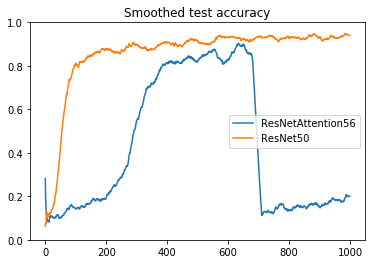

In [16]:
plt.title('Smoothed test accuracy')
plt.plot(smooth(resnetattention[1]), label='ResNetAttention56')
plt.plot(smooth(resnet[1]), label='ResNet50')
plt.ylim((0,1))
plt.legend()
plt.show()

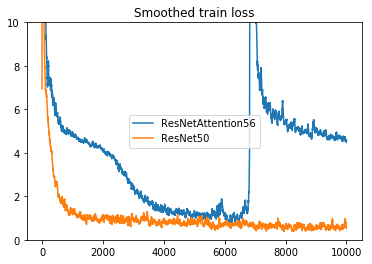

In [17]:
plt.title('Smoothed train loss')
plt.plot(smooth(resnetattention[0]), label='ResNetAttention56')
plt.plot(smooth(resnet[0]), label='ResNet50')
plt.ylim((0,10))
plt.legend()
plt.show()

In [19]:
level = 0.9
x = np.sum(resnetattention[2][:np.where(smooth(resnetattention[1]) > level)[0][0]]*10) / 60
print("ResNetAttention56: Accuracy became {} after {:4.2f} mins".format(level, x))
x = np.sum(resnet[2][:np.where(smooth(resnet[1]) > level)[0][0]]*100) / 60
print("ResNet50: Accuracy became {} after {:4.2f} mins".format(level, x))

ResNetAttention56: Accuracy became 0.9 after 68.07 mins
ResNet50: Accuracy became 0.9 after 327.19 mins
